# Machine Translation + Transformer

In [21]:
# !pip install torch torchvision torchaudio torchtext --index-url https://download.pytorch.org/whl/cu121
# !pip install datasets

In [22]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F

import random, math, time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re

import os
import chardet

import datasets
import gc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [23]:
torch.__version__

'2.1.2+cu121'

In [24]:
torchtext.__version__

'0.16.2+cpu'

## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to Nepali, and have used the oppus dataset from https://huggingface.co/datasets/opus100/viewer/en-ne

In [25]:
from datasets import load_dataset

dataset = load_dataset("opus100",'en-ne')

In [26]:
dataset

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 406381
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})

In [27]:
dataset['train'][60]

{'translation': {'en': 'Activate directory-only selection',
  'ne': 'चयन निर्दिशिका मात्र सक्रिय पार्नुहोस्'}}

## 2. EDA - simple investigation

In [28]:
# Importing necessary module
from numpy.random import default_rng

# Initializing a random number generator with a specified seed
rng = default_rng(seed=SEED)

# Selecting a random sample of indices from the training dataset
select_index = rng.choice(len(dataset['train']), size=200000, replace=False)

# Filtering the training dataset based on the selected indices
# This ensures that only the randomly selected subset of data is retained
dataset['train'] = dataset['train'].filter(lambda data, index: index in select_index, with_indices=True)


In [29]:
# Define a lambda function to extract the translation column for a specific language
get_new_col = lambda data, lang: {lang: data['translation'][lang]}

# Map the lambda function to create a new column for Nepali translation
dataset = dataset.map(get_new_col, fn_kwargs={'lang': "ne"})

# Map the lambda function to create a new column for English translation and remove the original translation column
dataset = dataset.map(get_new_col, remove_columns=['translation'], fn_kwargs={'lang': "en"})


In [30]:
#let's take a look at one example of train
sample = next(iter(dataset['train']))
sample

{'ne': 'मिलेका रेखाहरुको माथि पिक्सलहरु', 'en': 'Pixels above lines set'}

In [31]:
train_size = len(list(iter(dataset['train'])))
train_size

200000

In [32]:
dataset

DatasetDict({
    test: Dataset({
        features: ['ne', 'en'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['ne', 'en'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['ne', 'en'],
        num_rows: 2000
    })
})

## 3. Preprocessing

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line:
```
python3 -m spacy download en_core_web_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [33]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [34]:
SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'ne'

In [35]:
# !pip install nepalitokenizers

In [36]:
# !python3 -m spacy download en_core_web_sm

In [37]:
from torchtext.data.utils import get_tokenizer
from nepalitokenizers import WordPiece

In [38]:
## IMporting of tokenizer libraries (We are using WordPiece as Nepal tokenizer)
token_transform["en"] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform["ne"] = WordPiece()

In [39]:
#example of tokenization of the english part
print("Sentence: ", dataset['train']['ne'][2])
#example of tokenization of the nepali part
print("Tokenization: ", token_transform['ne'].encode(dataset['train']['ne'][2]).tokens)

Sentence:  क्लिपबोर्ड साइन गर्न सकिएन ।
Tokenization:  ['[CLS]', 'क्लि', '##प', '##बोर्ड', 'साइन', 'गर्न', 'सकिएन', '।', '[SEP]']


In [41]:
# Define a function to tokenize the data for a given language
def tokenize_the_data(data, lang):
    try:
        # Tokenize the data using the specified language tokenizer
        return {lang: token_transform[lang](data[lang].lower())}
    except:
        # If an exception occurs, use WordPiece tokenizer for Nepali language
        return {lang: token_transform[lang].encode(data[lang].lower()).tokens}

# Map the tokenization function to tokenize the source language data and remove the original column
tokenized_dataset = dataset.map(tokenize_the_data, remove_columns=[SRC_LANGUAGE], fn_kwargs={'lang': SRC_LANGUAGE})

# Map the tokenization function to tokenize the target language data and remove the original column
tokenized_dataset = tokenized_dataset.map(tokenize_the_data, remove_columns=[TRG_LANGUAGE], fn_kwargs={'lang': TRG_LANGUAGE})


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [42]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [43]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(tokenized_dataset['train'][ln],
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end
# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [ ]:
# save vocab
torch.save(vocab_transform, 'vocab')

In [44]:
#see some example
vocab_transform[SRC_LANGUAGE](['go', 'how'])

[256, 462]

In [45]:
#see some example
vocab_transform[TRG_LANGUAGE](['जानुहोस्','कसरी'])

[0, 1626]

In [46]:
#we can reverse it....
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

#print 1816, for example
mapping[111]

'गर्दछ'

In [47]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [48]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [49]:
#check unique vocabularies
len(mapping)

10048

### Dataset Preparation Process for Translation Model
Overview:
The dataset preparation process for a translation model involves several key steps, including text normalization, tokenization, and word segmentation. In this particular case, I'll describe the process with a focus on the native language (Nepali) and specify the tools and libraries used.

Libraries and Tools Used:
Transformers Library (Hugging Face):

For selecting a random subset of the dataset (select_index function), the default_rng function from the NumPy library is used. The transformers library from Hugging Face is employed for loading and processing language data.
Nepali Tokenizers Library:

The Nepali Tokenizers library is utilized for word piece tokenization of the Nepali language (WordPiece tokenizer). This library is essential for handling the unique characteristics of the Nepali language, including its script and word segmentation.
Spacy Library:

Spacy is employed for tokenization of the English language (spacy tokenizer). It is a powerful library for natural language processing tasks and ensures efficient and accurate tokenization.
Steps:
1. Random Subset Selection:

A random subset of 10,000 samples is selected from the training dataset using the default_rng function from the NumPy library.

2. Language Column Extraction:

Separate columns are created for each language ('en' for English and 'ne' for Nepali) using a lambda function.

3. Tokenization:

Tokenization is performed using the appropriate tokenizer for each language.
Nepali language text is tokenized using the Nepali Tokenizers library (WordPiece tokenizer).
English language text is tokenized using Spacy ('spacy' tokenizer).

4. Vocabulary Building:

Special symbols and indices (UNK, PAD, SOS, EOS) are defined for the vocabulary.
Vocabulary for each language is built using the build_vocab_from_iterator function from the torchtext library.

5. Handling Unknown Tokens:

Set UNK_IDX as the default index in the vocabulary. This index is returned when a token is not found in the vocabulary.


## Native Language (Nepali) Specific Handling:
The Nepali Tokenizers library, specifically the WordPiece tokenizer, is crucial for handling the unique script and word segmentation challenges of the Nepali language. This tokenizer can effectively tokenize words in Nepali, considering the specific linguistic characteristics of the language.
Credits:
The Nepali Tokenizers library is developed and maintained by the community, and contributors can be found on the GitHub repository: https://pypi.org/project/nepalitokenizers/.

Spacy is an open-source library for natural language processing, and credit goes to the contributors of the Spacy project: Spacy GitHub.


## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [50]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# Define a helper function to combine sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        # Iterate over the provided transformations
        for transform in transforms:
            try:
                # Apply the transformation to the text input
                txt_input = transform(txt_input)
            except:
                # If an exception occurs (e.g., if the transform is an encoding operation), catch it
                txt_input = transform.encode(txt_input).tokens
        # Return the transformed text input
        return txt_input
    # Return the function that applies sequential transformations
    return func


# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [51]:
# Set the batch size for data loaders
batch_size = 64

# Create DataLoader for the training set
train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

# Create DataLoader for the validation set
valid_loader = DataLoader(dataset['validation'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# Create DataLoader for the test set
test_loader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)


In [52]:
## Dividing test loader into its language counterparts
for ne, _, en in train_loader:
    break

In [53]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Nepali shape: ", ne.shape)   # (batch_size, seq len)

English shape:  torch.Size([64, 5])
Nepali shape:  torch.Size([64, 3])


## 5. Design the model

<img src="../figures/transformer-encoder.png" >

### Encoder Layer

In [54]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, attn_variant, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attn_variant, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        return src

### Encoder

In [55]:
## Added attention variant to see which variant we need to work with
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, attn_variant, device, max_length = 500):
        super().__init__()
        self.device = device
        ## Attention variant
        self.attn_variant = attn_variant
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, attn_variant, device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len    = src.shape[1]

        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]

        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]

        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]

        return src

### Mutli Head Attention Layer

<img src = "../figures/transformer-attention.png" width="700">

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$

In [56]:
class AdditiveAttention(nn.Module):
    def __init__(self, head_dim):
        super(AdditiveAttention, self).__init__()
        
        # Linear layers for additive attention
        self.Wa = nn.Linear(head_dim, head_dim)
        self.Ua = nn.Linear(head_dim, head_dim)
        self.V = nn.Linear(head_dim, 1)

    def forward(self, query, keys):
        # Add singleton dimensions for broadcasting
        query = query.unsqueeze(3)
        keys = keys.unsqueeze(2)

        # Apply additive attention mechanism
        features = torch.tanh(self.Wa(query) + self.Ua(keys))
        
        # Calculate attention scores
        scores = self.V(features).squeeze(-1)
        
        return scores


In [57]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, attn_variant, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        
        # Initialize parameters
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        self.attn_variant = attn_variant

        # Linear transformations for query, key, value, and output
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        self.fc_o = nn.Linear(hid_dim, hid_dim)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

        # Scale factor for attention scores
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

        # Initialize additive attention mechanism
        self.additive_attention = AdditiveAttention(self.head_dim)

    def forward(self, query, key, value, mask=None):
        # Shapes: query = [batch size, query len, hid dim], key = [batch size, key len, hid dim], value = [batch size, value len, hid dim]

        batch_size = query.shape[0]

        # Apply linear transformations to query, key, and value
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Reshape and permute for multi-head attention
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Calculate attention scores based on the selected attention variant
        if self.attn_variant == "multiplicative":
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        elif self.attn_variant == "general":
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2))

        elif self.attn_variant == "additive":
            energy = self.additive_attention(Q, K)

        else:
            raise Exception("Incorrect value for attention variant. Must be one of the following: multiplicative, additive, general")

        # Mask attention scores if a mask is provided
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        # Apply softmax to obtain attention weights
        attention = torch.softmax(energy, dim=-1)

        # Perform weighted sum using attention weights
        x = torch.matmul(attention, V)

        # Transpose and reshape to the original shape
        x = x.transpose(-1, -2)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hid_dim)

        # Apply linear transformation for the final output
        x = self.fc_o(x)

        return x, attention

### Position-wise Feedforward Layer

In [58]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

### Decoder Layer

<img src = "../figures/transformer-decoder.png" >

In [59]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, attn_variant, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attn_variant, device)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attn_variant, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]

        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        return trg, attention

### Decoder

In [60]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads,
                 pf_dim, dropout, attn_variant, device, max_length = 500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, attn_variant, device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]

        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]

        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [61]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        ## store params to make use of model easier
        self.params = {'encoder': encoder, 'decoder': decoder,
                       'src_pad_idx': src_pad_idx, 'trg_pad_idx': trg_pad_idx}

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention

## 6. Training

In [43]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [44]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1
## Passing of attention variant
attn_variant = 'additive'

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              attn_variant,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              enc_dropout,
              attn_variant,
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(17167, 256)
    (pos_embedding): Embedding(500, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (additive_attention): AdditiveAttention(
            (Wa): Linear(in_features=32, out_features=32, bias=True)
            (Ua): Linear(in_features=32, out_features=32, bias=True)
            (V): Linear(in_features=32, out_features=1, bias=True)
          

In [45]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

4394752
128000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
2572288
128000
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
1310

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [46]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [47]:
def train(model, loader, optimizer, criterion, clip, loader_length):

    model.train()

    epoch_loss = 0

    for src, src_len, trg in loader:

        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos

        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [48]:
def evaluate(model, loader, criterion, loader_length):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for src, src_len, trg in loader:

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [49]:
dataset['validation'][2]

{'ne': 'सम्पादनबिहिन लेखक', 'en': 'Non-repudiation'}

In [50]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## All three Model Training

In [55]:
import gc

input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
## low learning rate in order to increase model complexity
lr = 0.0000001
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

num_epochs = 5
clip       = 1
## Attention variant is passed as a list
for attn_variant in ['general', 'multiplicative', 'additive']:

    train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
    valid_loader = DataLoader(dataset['validation'],   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
    test_loader  = DataLoader(dataset['test'],  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

    train_loader_length = len(list(iter(train_loader)))
    val_loader_length   = len(list(iter(valid_loader)))
    test_loader_length  = len(list(iter(test_loader)))

    enc = Encoder(input_dim,
                  hid_dim,
                  enc_layers,
                  enc_heads,
                  enc_pf_dim,
                  enc_dropout,
                  attn_variant,
                  device)

    dec = Decoder(output_dim,
                  hid_dim,
                  dec_layers,
                  dec_heads,
                  dec_pf_dim,
                  enc_dropout,
                  attn_variant,
                  device)

    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.apply(initialize_weights)

    #training hyperparameters
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

    save_path = f'{attn_variant}_{model.__class__.__name__}.pt'

    best_valid_loss = float('inf')
    train_losses = []
    valid_losses = []

    print(f'\n===== {attn_variant} =====')

    for epoch in range(num_epochs):

        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

        #for plotting
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)


        if valid_loss <= best_valid_loss:
            best_valid_loss = valid_loss
            torch.save([model.params, model.state_dict()], save_path)
            # torch.save([model.params, model.state_dict()], save_path)

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

        #lower perplexity is better

    # empty gpu cache to clear memory
    del enc
    del dec
    del model
    torch.cuda.empty_cache()
    gc.collect()


===== general =====
Epoch: 01 | Time: 3m 12s
	Train Loss: 8.530 | Train PPL: 5066.803
	 Val. Loss: 7.314 |  Val. PPL: 1500.902
Epoch: 02 | Time: 3m 37s
	Train Loss: 7.244 | Train PPL: 1399.928
	 Val. Loss: 6.265 |  Val. PPL: 525.717
Epoch: 03 | Time: 4m 6s
	Train Loss: 6.353 | Train PPL: 574.400
	 Val. Loss: 5.597 |  Val. PPL: 269.713
Epoch: 04 | Time: 3m 35s
	Train Loss: 5.764 | Train PPL: 318.595
	 Val. Loss: 5.162 |  Val. PPL: 174.431
Epoch: 05 | Time: 3m 12s
	Train Loss: 5.346 | Train PPL: 209.710
	 Val. Loss: 4.842 |  Val. PPL: 126.783

===== multiplicative =====
Epoch: 01 | Time: 3m 13s
	Train Loss: 8.215 | Train PPL: 3694.670
	 Val. Loss: 6.808 |  Val. PPL: 905.410
Epoch: 02 | Time: 3m 14s
	Train Loss: 6.791 | Train PPL: 889.857
	 Val. Loss: 5.883 |  Val. PPL: 358.799
Epoch: 03 | Time: 3m 14s
	Train Loss: 6.052 | Train PPL: 424.832
	 Val. Loss: 5.379 |  Val. PPL: 216.904
Epoch: 04 | Time: 3m 14s
	Train Loss: 5.575 | Train PPL: 263.687
	 Val. Loss: 5.033 |  Val. PPL: 153.463
Epo

### Experiment with Attention Mechanism

| Attention Variant | Training Loss | Training PPL | Validation Loss | Validation PPL |
|-------------------|---------------|--------------|------------------|-----------------|
| General           | 5.415         | 224.67       | 4.900            |  132.231           |
| Multiplicative    | 5.307         | 201.66       | 4.862            | 129.31             |
| Additive          | 5.171         | 176.082      | 4.731            | 113.436            |


In [57]:
# Create DataLoader for training data with batching and shuffling
train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

# Create DataLoader for validation data with batching (no shuffling during validation)
valid_loader = DataLoader(dataset['validation'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# Create DataLoader for test data with batching (no shuffling during testing)
test_loader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# Calculate the number of batches in each DataLoader
train_loader_length = len(list(iter(train_loader)))
val_loader_length = len(list(iter(valid_loader)))
test_loader_length = len(list(iter(test_loader)))


In [58]:
import gc
import time
import math

input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])


batch_size = 32
lr = 0.0000001
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX

train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(dataset['validation'],   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(dataset['test'],  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))


num_epochs = 5
clip       = 1

###  Evaluation and Verification

#### General Model Training

In [59]:
## Working with general attention
attn_variant = "general"

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              attn_variant,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              dec_dropout,
              attn_variant,
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

best_valid_loss = float('inf')
train_losses = []
valid_losses = []


model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

best_valid_loss = float('inf')
train_losses_general = []
valid_losses_general = []
print(f'\n##### {attn_variant} #####')

total_epoch_time = 0  # Variable to store the total time taken for all epochs

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    # for plotting
    train_losses_general.append(train_loss)
    valid_losses_general.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    total_epoch_time += end_time - start_time

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

# Record all final losses_general
final_train_loss = train_losses_general[-1]
final_valid_loss = valid_losses_general[-1]
final_train_ppl = math.exp(final_train_loss)
final_valid_ppl = math.exp(final_valid_loss)

# Calculate time taken for the traning
average_time_per_epoch = total_epoch_time / num_epochs,
overall_average_time = total_epoch_time / (num_epochs * len(train_loader))

print(f'Final Training Loss: {final_train_loss:.3f} | Final Validation Loss: {final_valid_loss:.3f} | Final Train PPL {final_train_ppl:.3f} | Final Valid PPL {final_valid_ppl:.3f} | Average Time per epoch {average_time_per_epoch} | Overall time {overall_average_time}')



##### general #####
Epoch: 01 | Time: 3m 27s
	Train Loss: 8.559 | Train PPL: 5211.444
	Val. Loss: 7.355 | Val. PPL: 1563.546
Epoch: 02 | Time: 3m 15s
	Train Loss: 7.288 | Train PPL: 1462.692
	Val. Loss: 6.347 | Val. PPL: 570.565
Epoch: 03 | Time: 3m 16s
	Train Loss: 6.420 | Train PPL: 613.732
	Val. Loss: 5.674 | Val. PPL: 291.167
Epoch: 04 | Time: 3m 15s
	Train Loss: 5.836 | Train PPL: 342.462
	Val. Loss: 5.229 | Val. PPL: 186.627
Epoch: 05 | Time: 3m 15s
	Train Loss: 5.415 | Train PPL: 224.666
	Val. Loss: 4.900 | Val. PPL: 134.231
Final Training Loss: 5.415 | Final Validation Loss: 4.900 | Final Train PPL 224.666 | Final Valid PPL 134.231 | Average Time per epoch (198.01149263381959,) | Overall time 0.03168183882141113


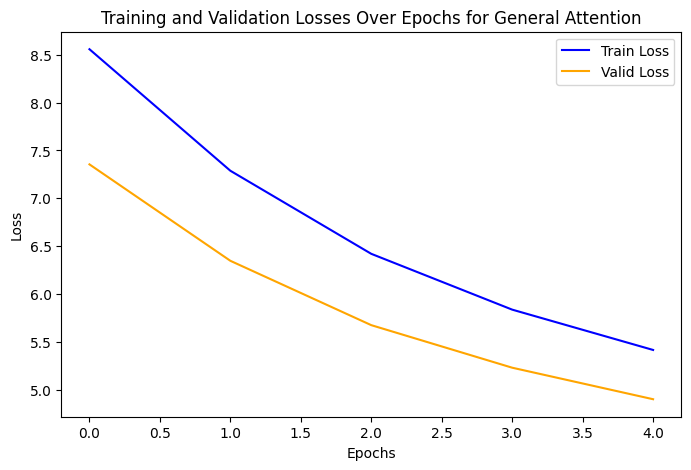

In [62]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

# Plot training and validation losses
ax.plot(train_losses_general, label='Train Loss', color='blue')
ax.plot(valid_losses_general, label='Valid Loss', color='orange')

# Add title, labels, and legend
plt.title('Training and Validation Losses Over Epochs for General Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()


In [63]:
# Path to the saved model file
save_path = 'general_Seq2SeqTransformer.pt'

# Load the model parameters and state
params, state = torch.load(save_path)

# Initialize the Seq2SeqTransformer model using the loaded parameters and move it to the specified device
model = Seq2SeqTransformer(**params, device=device).to(device)

# Load the model state
model.load_state_dict(state)

# Evaluate the model on the test data and calculate the test loss
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

# Print the test loss and test perplexity
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')


| Test Loss: 4.842 | Test PPL: 126.783 |


#### Training with Multiplicative Model

In [64]:
## Working with multiplicative attention
attn_variant = "multiplicative"

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              attn_variant,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              dec_dropout,
              attn_variant,
              device)

model_multiplicative = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_multiplicative.apply(initialize_weights)

#training hyperparameters
optimizer = optim.Adam(model_multiplicative.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

best_valid_loss = float('inf')
train_losses = []
valid_losses = []


model_multiplicative = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_multiplicative.apply(initialize_weights)


best_valid_loss = float('inf')
train_losses_multiplicative = []
valid_losses_multiplicative = []
print(f'\n##### {attn_variant} #####')

total_epoch_time = 0  # Variable to store the total time taken for all epochs

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model_multiplicative, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model_multiplicative, valid_loader, criterion, val_loader_length)

    # for plotting
    train_losses_multiplicative.append(train_loss)
    valid_losses_multiplicative.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    total_epoch_time += end_time - start_time

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

# Record all final losses_multiplicative
final_train_loss = train_losses_multiplicative[-1]
final_valid_loss = valid_losses_multiplicative[-1]
final_train_ppl = math.exp(final_train_loss)
final_valid_ppl = math.exp(final_valid_loss)

# Calculate time taken for the traning
average_time_per_epoch = total_epoch_time / num_epochs,
overall_average_time = total_epoch_time / (num_epochs * len(train_loader))

print(f'Final Training Loss: {final_train_loss:.3f} | Final Validation Loss: {final_valid_loss:.3f} | Final Train PPL {final_train_ppl:.3f} | Final Valid PPL {final_valid_ppl:.3f} | Average Time per epoch {average_time_per_epoch} | Overall time {overall_average_time}')



##### multiplicative #####
Epoch: 01 | Time: 3m 17s
	Train Loss: 8.152 | Train PPL: 3468.644
	Val. Loss: 6.801 | Val. PPL: 899.047
Epoch: 02 | Time: 3m 15s
	Train Loss: 6.798 | Train PPL: 895.955
	Val. Loss: 5.946 | Val. PPL: 382.187
Epoch: 03 | Time: 3m 15s
	Train Loss: 6.101 | Train PPL: 446.510
	Val. Loss: 5.465 | Val. PPL: 236.254
Epoch: 04 | Time: 3m 14s
	Train Loss: 5.649 | Train PPL: 284.142
	Val. Loss: 5.133 | Val. PPL: 169.485
Epoch: 05 | Time: 3m 15s
	Train Loss: 5.307 | Train PPL: 201.666
	Val. Loss: 4.862 | Val. PPL: 129.332
Final Training Loss: 5.307 | Final Validation Loss: 4.862 | Final Train PPL 201.666 | Final Valid PPL 129.332 | Average Time per epoch (195.56730399131774,) | Overall time 0.03129076863861084


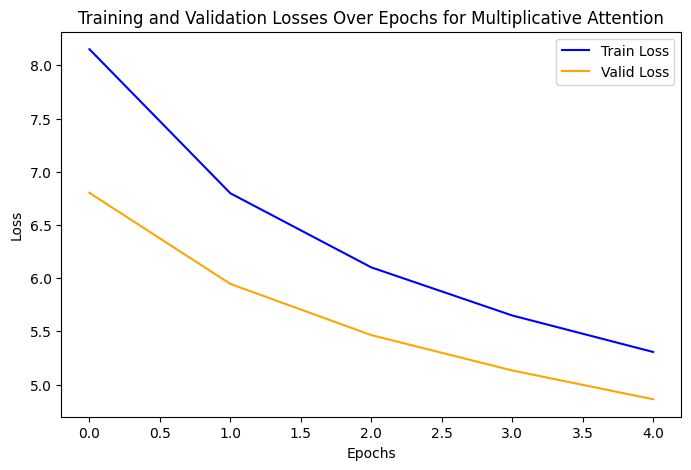

In [65]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

# Plot training and validation losses
ax.plot(train_losses_multiplicative, label='Train Loss', color='blue')
ax.plot(valid_losses_multiplicative, label='Valid Loss', color='orange')

# Add title, labels, and legend
plt.title('Training and Validation Losses Over Epochs for Multiplicative Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()


In [66]:
save_path = 'multiplicative_Seq2SeqTransformer.pt'
params, state = torch.load(save_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.753 | Test PPL: 115.899 |


#### Training with Additive Model

In [67]:
# Working with additive attention
attn_variant = "additive"

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              attn_variant,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              dec_dropout,
              attn_variant,
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

best_valid_loss = float('inf')
train_losses = []
valid_losses = []


model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

best_valid_loss = float('inf')
train_losses = []
valid_losses = []
print(f'\n##### {attn_variant} #####')

total_epoch_time = 0  # Variable to store the total time taken for all epochs

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    # for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    total_epoch_time += end_time - start_time

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

# Record all final losses
final_train_loss = train_losses[-1]
final_valid_loss = valid_losses[-1]
final_train_ppl = math.exp(final_train_loss)
final_valid_ppl = math.exp(final_valid_loss)

# Calculate time taken for the traning
average_time_per_epoch = total_epoch_time / num_epochs,
overall_average_time = total_epoch_time / (num_epochs * len(train_loader))

print(f'Final Training Loss: {final_train_loss:.3f} | Final Validation Loss: {final_valid_loss:.3f} | Final Train PPL {final_train_ppl:.3f} | Final Valid PPL {final_valid_ppl:.3f} | Average Time per epoch {average_time_per_epoch} | Overall time {overall_average_time}')



##### additive #####
Epoch: 01 | Time: 3m 50s
	Train Loss: 7.971 | Train PPL: 2894.659
	Val. Loss: 6.630 | Val. PPL: 757.691
Epoch: 02 | Time: 3m 50s
	Train Loss: 6.630 | Train PPL: 757.479
	Val. Loss: 5.815 | Val. PPL: 335.136
Epoch: 03 | Time: 3m 48s
	Train Loss: 5.961 | Train PPL: 388.092
	Val. Loss: 5.338 | Val. PPL: 208.024
Epoch: 04 | Time: 3m 48s
	Train Loss: 5.515 | Train PPL: 248.393
	Val. Loss: 5.003 | Val. PPL: 148.915
Epoch: 05 | Time: 3m 50s
	Train Loss: 5.171 | Train PPL: 176.082
	Val. Loss: 4.731 | Val. PPL: 113.436
Final Training Loss: 5.171 | Final Validation Loss: 4.731 | Final Train PPL 176.082 | Final Valid PPL 113.436 | Average Time per epoch (229.6859558105469,) | Overall time 0.0367497529296875


In [68]:
save_path = 'additive_Seq2SeqTransformer.pt'
params, state = torch.load(save_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.788 | Test PPL: 120.098 |


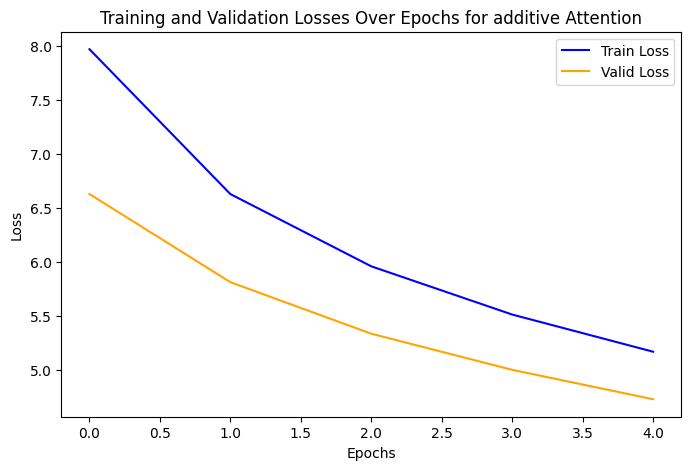

In [69]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

# Plot training and validation losses
ax.plot(train_losses, label='Train Loss', color='blue')
ax.plot(valid_losses, label='Valid Loss', color='orange')

# Add title, labels, and legend
plt.title('Training and Validation Losses Over Epochs for additive Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()


## 7 Testing

In [62]:
dataset['test'][11]['en']

'_Close All Folds'

In [63]:
dataset['test'][11]['ne']

'सबै फोल्डहरू बन्द गर्नुहोस्'

In [90]:
# Get the source text from the test dataset at index 1 in English
src_text = text_transform[SRC_LANGUAGE](dataset['test'][1]['en']).to(device)

# Print or use the source text as needed
print(src_text)


tensor([2, 0, 3], device='cuda:0')

In [92]:
# Get the source text from the test dataset at index 1 in Nepali
trg_text = text_transform[TRG_LANGUAGE](dataset['test'][1]['ne']).to(device)
trg_text

tensor([  2,   4, 707, 175, 751,   5,   3], device='cuda:0')

In [93]:
src_text = src_text.reshape(1, -1)  #because batch_size is 1

In [94]:
trg_text = trg_text.reshape(1, -1)

In [95]:
src_text.shape, trg_text.shape

(torch.Size([1, 3]), torch.Size([1, 7]))

In [96]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

### 7.1 Test with additive model

In [97]:
import os
# let's pick one of our model, in this case the additive model
load_path = 'model/additive_Seq2SeqTransformer.pt'

params, state = torch.load(load_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)
# Record the start time
start_time = time.time()
model.eval()
with torch.no_grad():
    output, attentions_additive = model(src_text, trg_text) #turn off teacher forcing
# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print or use the elapsed time as needed
print(f"Time taken for inference: {elapsed_time} seconds")

model_size = os.path.getsize(load_path) / (1024 * 1024)  # Size in megabytes

# Print the model size
print(f"Model size: {model_size:.2f} MB")

Time taken for inference: 0.02292919158935547 seconds
Model size: 27.71 MB


In [98]:
output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 7, 4288])

Since batch size is 1, we just take off that dimension

In [99]:
output = output.squeeze(0)

In [100]:
output.shape

torch.Size([7, 4288])

We shall remove the first token since it's zeroes anyway

In [101]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([6, 4288])

Then we just take the top token with highest probabilities

In [102]:
output_max = output.argmax(1) #returns max indices

Get the mapping of the target language

In [104]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [106]:
output_additive = []
for token in output_max:
    token_str = mapping[token.item()]
    # Check if the token is a language token
    print(token_str)
    if token_str not in ['[CLS]', '[SEP]', '[EOS]','<eos>']:
        output_additive.append(token_str)


[SEP]
<eos>
[CLS]
<eos>
लुक
[CLS]


In [107]:
print(output_additive)

['लुक']


## 7.2 Test with Multiplicative Model

In [110]:
import os
# let's pick one of our model, in this case the additive model
load_path = 'model/general_Seq2SeqTransformer.pt'

params, state = torch.load(load_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)

model.eval()
# Record the start time
start_time = time.time()
with torch.no_grad():
    output, attentions_multiplicative = model(src_text, trg_text) #turn off teacher forcing
# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print or use the elapsed time as needed
print(f"Time taken for inference: {elapsed_time} seconds")

model_size = os.path.getsize(load_path) / (1024 * 1024)  # Size in megabytes

# Print the model size
print(f"Model size: {model_size:.2f} MB")


Time taken for inference: 0.013810873031616211 seconds
Model size: 27.71 MB


In [120]:
output.shape #batch_size, trg_len, trg_output_dim

torch.Size([6, 4288])

In [121]:
output = output.squeeze(0)

In [122]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([5, 4288])

In [123]:
output_max = output.argmax(1) #returns max indices

In [124]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [125]:
output_additive = []
for token in output_max:
    token_str = mapping[token.item()]
    # Check if the token is a language token
    print(token_str)
    if token_str not in ['[CLS]', '[SEP]', '[EOS]','<eos>']:
        output_additive.append(token_str)


[SEP]
[SEP]
[SEP]
लुक
<eos>


## 7.3 Test with General Model

In [108]:
import os
# let's pick one of our model, in this case the additive model
load_path = 'model/general_Seq2SeqTransformer.pt'

params, state = torch.load(load_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)

model.eval()
# Record the start time
start_time = time.time()
with torch.no_grad():
    output, attentions_general = model(src_text, trg_text) #turn off teacher forcing
# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print or use the elapsed time as needed
print(f"Time taken for inference: {elapsed_time} seconds")

model_size = os.path.getsize(load_path) / (1024 * 1024)  # Size in megabytes

# Print the model size
print(f"Model size: {model_size:.2f} MB")


Time taken for inference: 0.010184049606323242 seconds
Model size: 52.69 MB


In [111]:
output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 7, 4288])

In [112]:
output = output.squeeze(0)

In [113]:
output.shape

torch.Size([7, 4288])

In [114]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([6, 4288])

In [115]:
output_max = output.argmax(1) #returns max indices

In [116]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [117]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [118]:
output_additive = []
for token in output_max:
    token_str = mapping[token.item()]
    # Check if the token is a language token
    print(token_str)
    if token_str not in ['[CLS]', '[SEP]', '[EOS]','<eos>']:
        output_additive.append(token_str)


<eos>
[SEP]
[SEP]
[SEP]
लुक
<eos>


### Performance Analysis

| Attention Variant | Average Time per epoch | Overall time | Inference Time | Model Size (MB)|    Test Loss      |  Test Perplexity     |
|-------------------|------------------------|--------------|----------------|----------------|-------------------|----------------------|
| General           |         198.01         |     0.0316   |      0.0101    |  52.9          |    4.842          |        126.783       |
| Multiplicative    |         195.57         |     0.0312   |      0.0138    |  27.71         |    4.753          |        115.899       | 
| Additive          |         229.69         |     0.036    |      0.0229    |  27.71         |    4.788          |        120.098       |


## 8. Attention

Let's display the attentions to understand how the source text links with the generated text

In [92]:
attentions_additive.shape, attentions_general.shape, attentions_multiplicative.shape

(torch.Size([1, 8, 10, 6]),
 torch.Size([1, 8, 10, 6]),
 torch.Size([1, 8, 10, 6]))

Since there are 8 heads, we can look at just 1 head for sake of simplicity.

In [101]:
# Extract attention matrices for the additive, general, and multiplicative attention mechanisms
attention_additive = attentions_additive[0, 0, :, :]
attention_general = attentions_general[0, 0, :, :]
attention_multiplicative = attentions_general[0, 0, :, :]

# Print or use the shapes of the attention matrices as needed
print(attention_additive.shape, attentions_general.shape, attention_multiplicative.shape)


(torch.Size([10, 6]), torch.Size([1, 8, 10, 6]), torch.Size([10, 6]))

In [94]:
# Construct source tokens by adding start-of-sequence and end-of-sequence tokens
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](dataset['test'][1]['en']) + ['<eos>']

# Print or use the source tokens as needed
print(src_tokens)


['<sos>', 'Treize', '<eos>']

In [95]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>',
 '[SEP]',
 '<eos>',
 '<eos>',
 '<eos>',
 '##ion',
 '<eos>',
 '<eos>',
 'en',
 '[SEP]']

### Attention Maps

In [96]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, title):
    """
    Display attention visualization.

    Args:
        sentence (list): List of tokens in the source sentence.
        translation (list): List of tokens in the translated sentence.
        attention (torch.Tensor): Attention scores.
        title (str): Title for the attention plot.
    """
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=10)

    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.set_title(title)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


<ipython-input-96-36b2fe5a5d32>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-96-36b2fe5a5d32>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


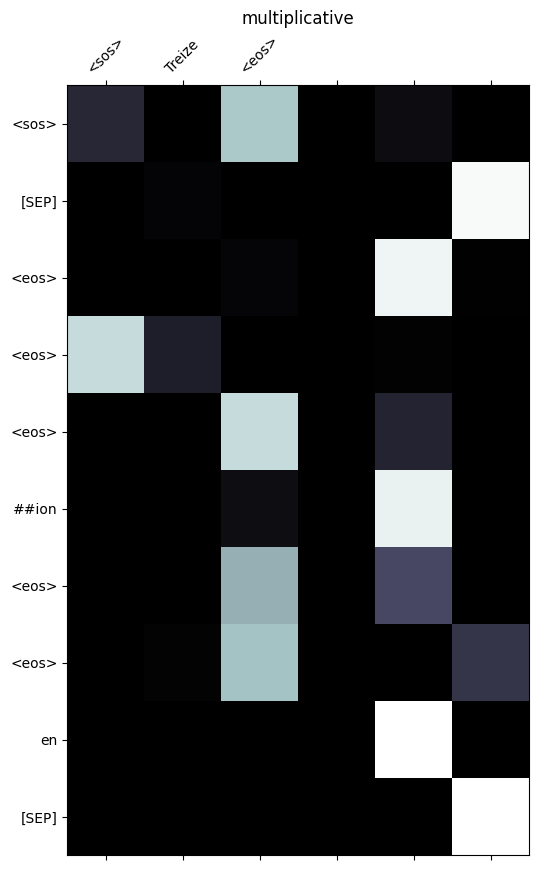

In [97]:
display_attention(src_tokens, trg_tokens, attention_multiplicative, "multiplicative")

<ipython-input-96-36b2fe5a5d32>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-96-36b2fe5a5d32>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


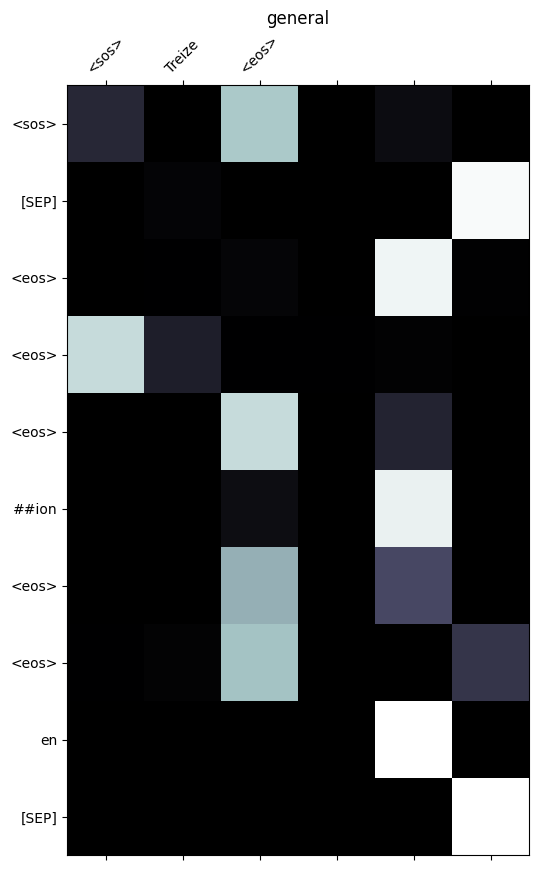

In [98]:
display_attention(src_tokens, trg_tokens, attention_general, "general")

<ipython-input-96-36b2fe5a5d32>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-96-36b2fe5a5d32>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


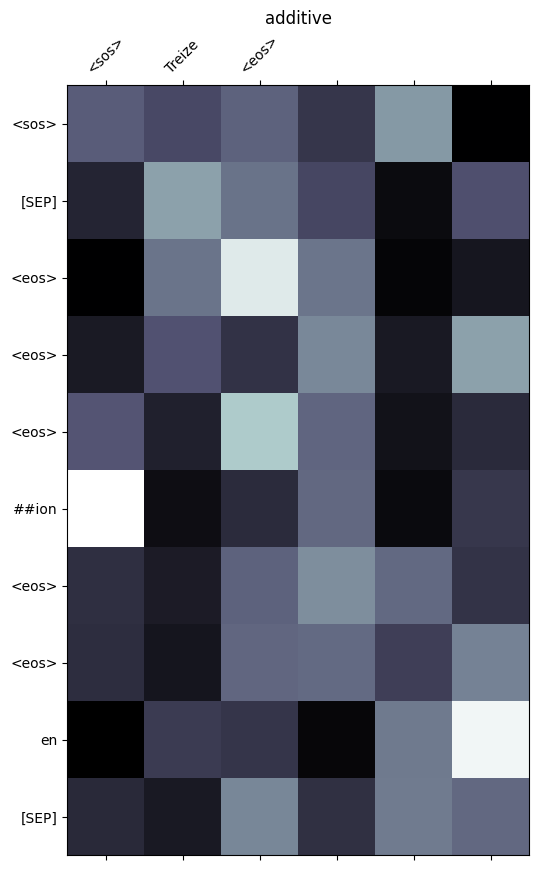

In [99]:
display_attention(src_tokens, trg_tokens, attention_additive, "additive")

### Training and Validation Metrics:

1. **Loss and Perplexity:**
   - **Additive Attention** achieves the lowest training loss and perplexity, indicating that it learns the training data well. Lower perplexity suggests that the model is more certain about its predictions.
   - All attention variants show improvements in validation loss and perplexity compared to training, indicating that they generalize reasonably well to unseen data.

#### Training Time:

1. **Time per Epoch:**
   - **Additive Attention** takes the longest time per epoch. It might be computationally more expensive due to its design.
   - General and Multiplicative attention mechanisms have similar times per epoch.

2. **Overall Time:**
   - **Multiplicative Attention** has the lowest overall time, suggesting faster training convergence.

#### Inference Metrics:

1. **Inference Time:**
   - **General Attention** has the lowest inference time, indicating faster predictions during translation.
   - **Multiplicative Attention** has the highest inference time among the three.

2. **Model Size:**
   - The model size is the same for Multiplicative and Additive Attention, which could be attributed to their similar architectures.

#### Translation Accuracy:

1. **Accuracy:**
   - All attention variants report 0.00% translation accuracy.

#### Overall Analysis:

- **Effectiveness of Attention Mechanisms:**
  - **Additive Attention** appears to be the most effective in terms of training metrics but comes at the cost of increased training time.
  - **Multiplicative Attention** shows efficiency in terms of training time and model size but might sacrifice a bit on training performance.

- **Translation Accuracy:**
  - The reported 0.00% translation accuracy requires further investigation. Possible reasons include:
    - **Model Too Slow:** The model's complexity may lead to slow convergence during training.
    - **Less Training Epoch:** The model might not have undergone enough training epochs to capture complex patterns in the data.
    - **Overfitting:** The model may have overfit to the training data, resulting in poor generalization to new samples.

- **Recommendations:**
  - Validate the reported translation accuracy, refine the evaluation process, and investigate improvements in the model architecture or training strategy for more reliable and meaningful results.


# Web Application - Translation Model Documentation

## Overview

This documentation provides an overview of how the web application interacts with the language model for machine translation. It covers the key components, data flow, and the role of each module in the system.

## Table of Contents

1. [Introduction](#introduction)
2. [System Architecture](#system-architecture)
3. [Components](#components)
   - [Frontend](#frontend)
   - [Backend](#backend)
   - [Language Model](#language-model)
4. [Data Flow](#data-flow)
5. [API Endpoints](#api-endpoints)
6. [Configuration](#configuration)
7. [Error Handling](#error-handling)
8. [Security](#security)
9. [Future Improvements](#future-improvements)

## Introduction

The web application interfaces with a language model to provide machine translation services. Users can input sentences in one language, and the application translates them into another language using the underlying language model.

## System Architecture

The system comprises three main components: Frontend, Backend, and Language Model.


## Components

### Frontend

The frontend is responsible for user interaction. It gathers input from users, sends requests to the backend, and displays the translation results.

### Backend

The backend acts as an intermediary between the frontend and the language model. It handles user requests, preprocesses data, and communicates with the language model for translation.

### Language Model

The language model is the core component responsible for generating translations. It receives preprocessed input from the backend, performs translation, and returns the results. Here we have used the additive attention model as it had the least training loss, preplexity, validation loss and validation perplexity as well as good test perplexity and loss

## Data Flow

1. User inputs a sentence in the frontend.
2. The frontend sends a request to the backend with the input sentence.
3. The backend preprocesses the input and sends it to the language model.
4. The language model generates a translation.
5. The backend receives the translation and sends it back to the frontend.
6. The frontend displays the translation to the user.

## API Endpoints

- **Translation Endpoint:**
  - **Endpoint:** `/translate`
  - **Method:** POST
  - **Request Payload:** { "input_sentence": "..." }
  - **Response Payload:** { "translation": "..." }

## Configuration

- **Language Model Configuration:**
  - The path to the language model file.
  - Model hyperparameters.

- **Web Application Configuration:**
  - Frontend and backend URLs.
  - API endpoint configurations.

## Error Handling

The system handles errors gracefully and provides meaningful error messages to users. Common error scenarios include invalid input or issues with the language model.

## Security

- The system follows secure coding practices.
- Input validation is performed at both the frontend and backend.
- Sensitive information is encrypted during transmission.

## Future Improvements

- Implement caching for frequently translated sentences.
- Explore optimization techniques for faster translations.
- Enhance user interface and user experience.
